In [29]:

import pandas as pd
import numpy as np
import sys
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from inmoose import limma
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#Find the utils Directory
sys.path.append(os.path.abspath("../../"))
from src.utils.ConvertTextToCsv import TextToCsv
from src.utils.Preprocessing import elimnation_zeros, total_type_len_type_cancer
from src.utils.plots import PCA_4_scatter_matrix_log2, box_plot, density_plot

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<font size="4">Get the DataFrame from the clinical Data</font>

In [30]:
df_clincal_data = pd.read_csv("../../data/raw/brca_tcga_pub2015_clinical_data.tsv", sep='\t')
list_df = total_type_len_type_cancer(df_clincal_data)
df_clincal_data["Tumor-Cancer"] = list_df

Luminal A: 330 - Total(%): 0.40
Luminal B: 81 - Total(%):0.10
HER2-enriched: 23 - Total(%):0.03
TNBC: 85 - Total(%)0.10 
UNK: 298 - Total(%) 0.36


In [31]:
df_clincal_data["Tumor-Cancer"].unique()

array(['<UNK>', 'Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'],
      dtype=object)

<font size="4">Get the DataFrame from the mRNA-Seq Data</font>

In [32]:
df_mRNA = pd.read_csv("../../data/raw/data_mrna_seq_v2_rsem.txt", header=None)
df_mRNA_transformed = TextToCsv("../../data/raw/data_mrna_seq_v2_rsem.txt")

Shape of the CSV: (20440, 819)


<font size="4">Transform the mRNA-Seq for merging the two DataFrames</font>

In [33]:
df_mRNA_transformed = df_mRNA_transformed.drop(columns=["Hugo_Symbol", "Entrez_Gene_Id"], axis=0)
df_mrna = df_mRNA_transformed.T.reset_index()
df_mRNA_final = df_mrna.rename(columns={"index":"Sample ID"})

<font size="4">Merging the clinical DataSet and mRNA-Seq</font>

In [34]:
df_merged = pd.merge(df_mRNA_final, df_clincal_data, right_on="Sample ID", left_on="Sample ID")

<font size="4">Getting the information of the columns of the mRNA-Seq and classes</font>

In [35]:
comparation_df = df_merged.loc[
    df_merged["Tumor-Cancer"].isin(["Luminal A", "Luminal B", "TNBC", "HER2-enriched"]),
    ["Tumor-Cancer"] + list(df_merged.columns[1:20441])
]
comparation_df["Tumor-Cancer"].unique()

array(['Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'], dtype=object)

In [36]:
zeros_reduced_df = elimnation_zeros(comparation_df)

Max of zeros per row in the dataset: 519
Avg of zeros per row in the dataset: 74.00381604696673
Median of zeros per row in the dataset: 0.0
Min of zeros per row in the dataset: 0
After the 0 elimination: 16270


In [37]:
print(f"Samples: {zeros_reduced_df.shape[0]}, Genes: {zeros_reduced_df.shape[1]}")

Samples: 519, Genes: 16270


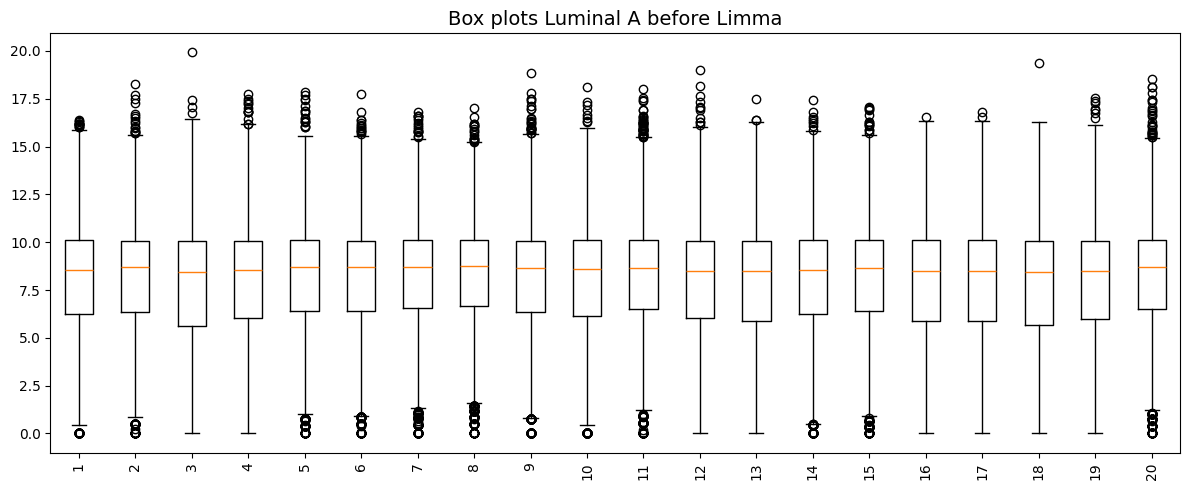

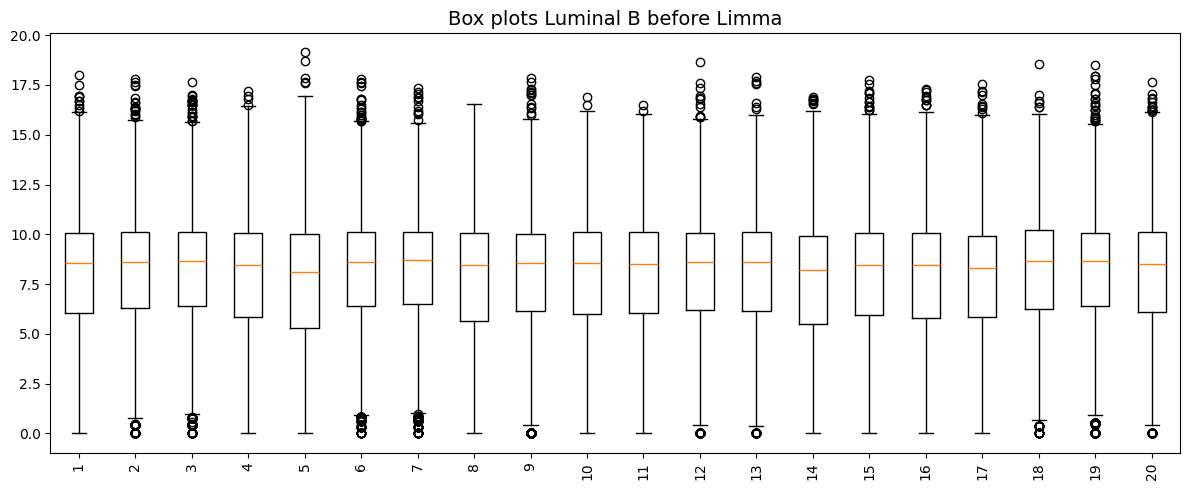

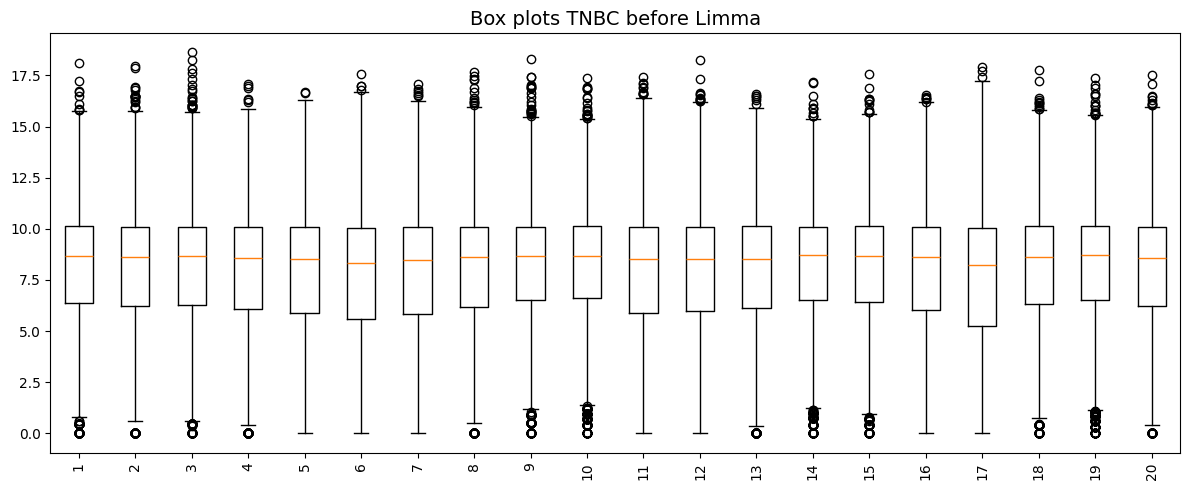

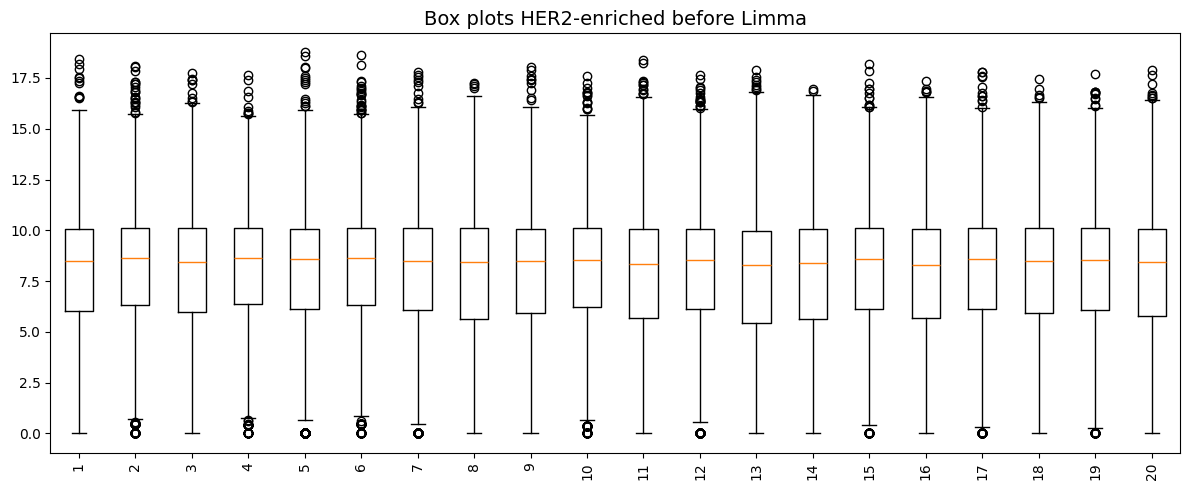

In [38]:
min_range = 1
max_range = 21

box_plot(data=zeros_reduced_df, title="Box plots Luminal A before Limma",
         type_cancer="Luminal A", range_min=min_range,range_max=max_range)

box_plot(data=zeros_reduced_df, title="Box plots Luminal B before Limma",
         type_cancer="Luminal B", range_min=min_range,range_max=max_range)

box_plot(data=zeros_reduced_df, title="Box plots TNBC before Limma",
         type_cancer="TNBC", range_min=min_range,range_max=max_range)

box_plot(data=zeros_reduced_df, title="Box plots HER2-enriched before Limma",
         type_cancer="HER2-enriched", range_min=min_range,range_max=max_range)


<font size="4">Density Plot before Limma</font>

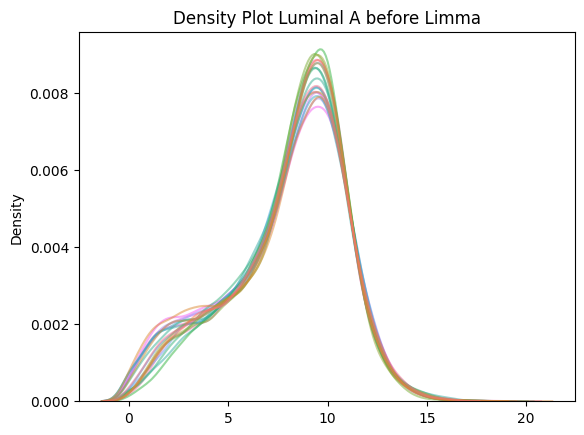

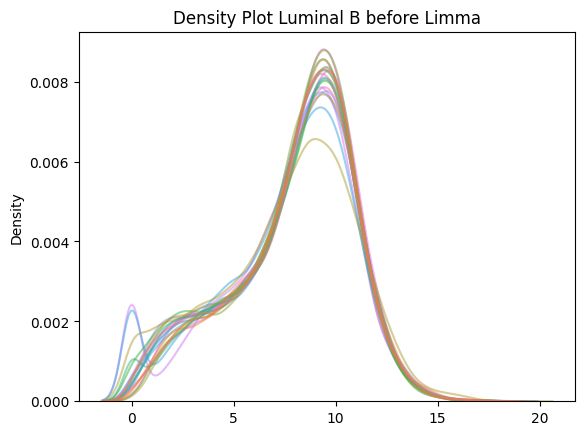

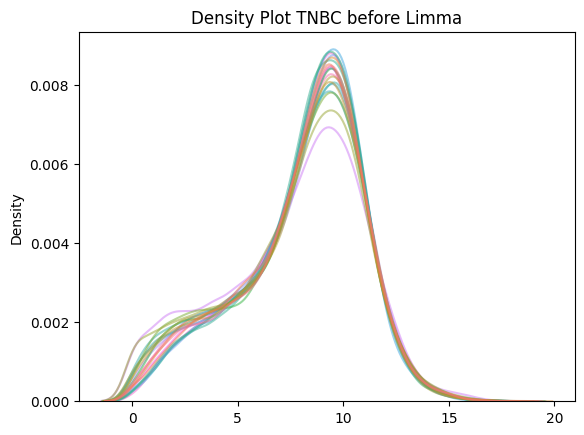

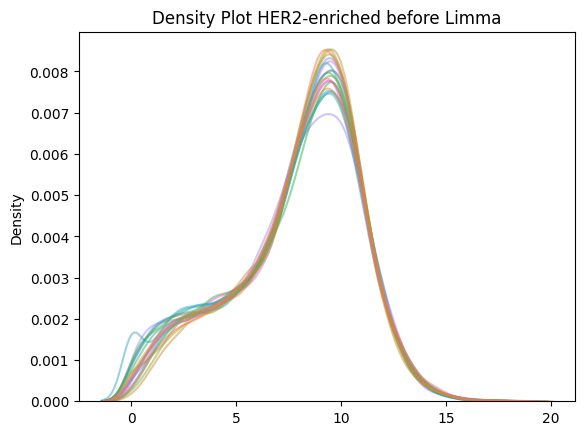

In [40]:

density_plot(data=zeros_reduced_df, title="Density Plot Luminal A before Limma",
         type_cancer="Luminal A", range_min=min_range,range_max=max_range)

density_plot(data=zeros_reduced_df, title="Density Plot Luminal B before Limma",
         type_cancer="Luminal B", range_min=min_range,range_max=max_range)

density_plot(data=zeros_reduced_df, title="Density Plot TNBC before Limma",
         type_cancer="TNBC", range_min=min_range,range_max=max_range)

density_plot(data=zeros_reduced_df, title="Density Plot HER2-enriched before Limma",
         type_cancer="HER2-enriched", range_min=min_range,range_max=max_range)


In [41]:
PCA_4_scatter_matrix_log2(df=zeros_reduced_df, cancer_types=["Luminal A", "Luminal B", "TNBC", "HER2-enriched"])

<font size="4">Transformation of Log2 of the data</font>

In [42]:
metadata = pd.DataFrame(zeros_reduced_df["Tumor-Cancer"], index=zeros_reduced_df.index)
metadata.columns = ["Tumor_Cancer"]
counts_data = zeros_reduced_df.drop(columns=["Tumor-Cancer"])

counts_data = np.log2(counts_data + 1)
expr = counts_data.T
print(f"Genes {counts_data.shape[0]}, Samples {counts_data.shape[1]}")
print("metadata rows:", metadata.shape[0])
print("counts_data rows:", counts_data.shape[0])
print("counts_data cols:", counts_data.shape[1])
(expr.columns == metadata.index).all()
expr

Genes 519, Samples 16269
metadata rows: 519
counts_data rows: 519
counts_data cols: 16269


,2,6,7,8,10,12,13,14,15,16,...,807,808,809,810,811,812,813,814,815,816
0,2.444296,2.570924,4.899949,3.112433,3.382792,2.996570,2.151859,2.273038,3.653908,4.643695,...,0.000000,1.986375,2.229557,2.868292,3.919226,3.159355,1.701283,1.176514,2.595217,2.430071
1,7.268146,7.086118,10.129532,6.912602,7.581941,6.768751,7.937853,7.543773,6.916961,7.868241,...,6.676472,6.662609,8.127028,7.696534,6.883010,7.244919,6.862176,7.316145,6.973068,6.746145
2,6.242256,6.014552,7.389904,6.354172,7.140522,7.781994,8.370145,8.474928,8.040277,7.382579,...,7.043724,8.524713,7.381731,6.713947,8.267781,9.080625,8.405986,7.726191,8.340378,9.117783
7,2.721241,2.524916,2.159242,2.740237,2.694323,3.498391,2.745323,2.492571,3.524114,2.991808,...,2.607603,2.372869,2.702081,2.464877,2.318982,2.859930,2.370192,1.808962,2.777893,1.801904
14,8.232633,9.315427,6.116645,7.529135,6.143283,7.628699,9.639667,7.828953,9.792776,6.161692,...,11.926662,9.391988,8.579921,8.460521,7.300110,7.771670,8.654642,7.939866,10.155137,10.072181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20434,9.909282,10.094920,10.432242,10.462541,9.414692,9.621045,9.498870,9.510764,9.669212,10.007870,...,8.035448,8.739215,9.526176,9.024839,9.713130,9.746702,9.311246,8.907137,9.418254,9.479537
20435,11.554980,11.566577,9.210035,12.158318,11.762762,11.322840,12.075424,12.089489,11.544202,11.754348,...,12.404736,12.495809,12.714952,13.491285,11.410728,12.267846,12.023917,12.693090,12.349216,12.276868
20436,9.856998,9.905974,10.813724,10.208782,9.497850,10.072896,9.425682,9.810001,9.351732,10.659348,...,8.528887,9.915091,10.202031,10.173876,10.286328,11.112330,10.291029,9.345068,10.461216,10.006849
20437,10.072055,9.491438,10.384400,10.507657,10.466670,9.807368,9.425682,9.152457,8.792045,9.357845,...,7.246112,8.992540,9.246410,8.951643,10.095657,9.380728,9.596459,9.609892,9.480557,9.742932


In [43]:
metadata_aligned = metadata.loc[expr.columns].copy()
dummies = pd.get_dummies(metadata_aligned["Tumor_Cancer"]).astype(float)
design = dummies
print(design.shape)
print(design.columns)

design

(519, 4)
Index(['HER2-enriched', 'Luminal A', 'Luminal B', 'TNBC'], dtype='object')


,HER2-enriched,Luminal A,Luminal B,TNBC
2,0.0,1.0,0.0,0.0
6,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,1.0
8,0.0,0.0,1.0,0.0
10,0.0,0.0,0.0,1.0
...,...,...,...,...
812,0.0,1.0,0.0,0.0
813,0.0,1.0,0.0,0.0
814,0.0,0.0,0.0,1.0
815,0.0,1.0,0.0,0.0


<font size="4">Limma functions</font>

In [44]:
#This is for fitting the models
limma_fit_models = limma.lmFit(obj=expr, design=design)

#Emperical moderate Bayes (eBayes)
limma_fit_models = limma.eBayes(limma_fit_models)

#Obtain the table of Results
results = limma.topTable(limma_fit_models, number=np.inf)


#Transform to pandas dataframe
results_df = pd.DataFrame(results)

results_df.rename(columns={
                        "column0":"HER2-enriched",
                        "column1":"Luminal A",
                        "column2":"Luminal B",
                        "column3":"TNBC"
                        
                           })


,HER2-enriched,Luminal A,Luminal B,TNBC,AveExpr,F,pvalue,adj_pvalue
20427,9.112677,8.764592,8.821837,9.308579,8.878044,36827.278019,0.000000e+00,0.000000e+00
38,11.161230,11.176952,11.153502,11.159093,11.169671,70245.057744,0.000000e+00,0.000000e+00
40,8.572738,8.670099,8.693672,9.164921,8.750504,41235.258704,0.000000e+00,0.000000e+00
41,8.492468,8.986444,8.851203,8.822268,8.916558,28922.614287,0.000000e+00,0.000000e+00
42,11.935465,11.353239,11.710176,11.946263,11.531871,43627.629496,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
5630,2.679652,1.837475,2.586356,1.636177,1.958707,131.465933,1.704643e-112,1.705062e-112
4537,1.177123,3.849702,3.187019,1.143594,3.184643,126.226241,5.823399e-108,5.824473e-108
16977,1.054401,3.402690,2.169965,1.787912,2.841770,125.603897,2.011869e-107,2.012117e-107
13607,2.598983,1.471813,1.876862,2.484594,1.750850,110.503922,2.311433e-94,2.311576e-94


In [45]:
N = 5000
top_genes = results_df.sort_values("pvalue").head(N).index
expr_sub = expr.loc[top_genes]

<font size="4">Box Plots after Limma</font>

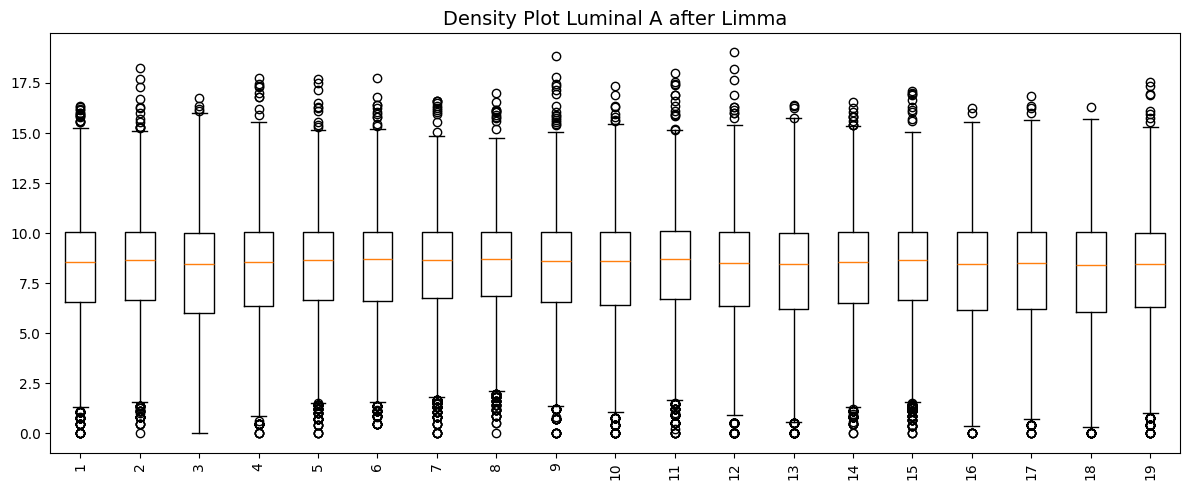

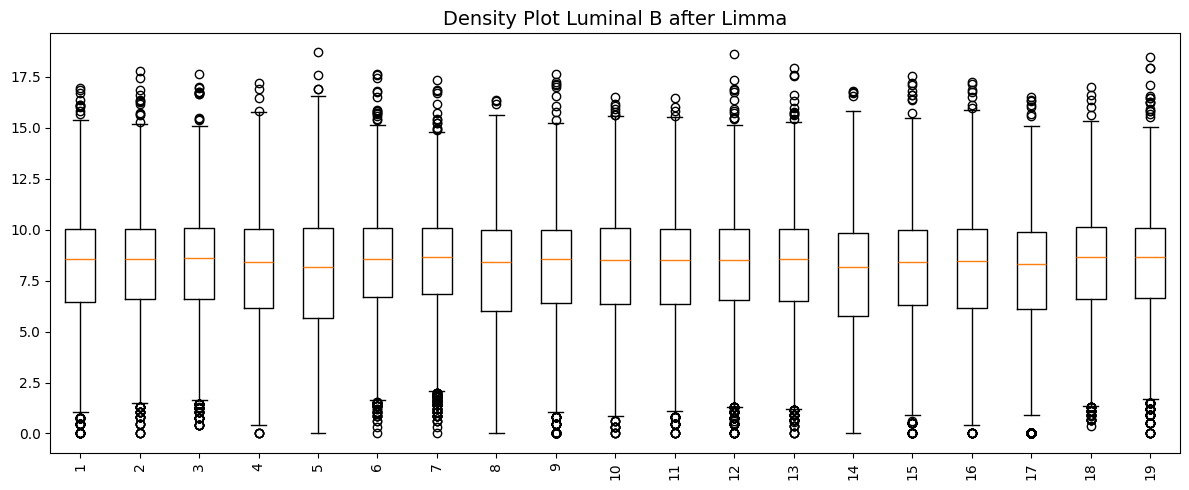

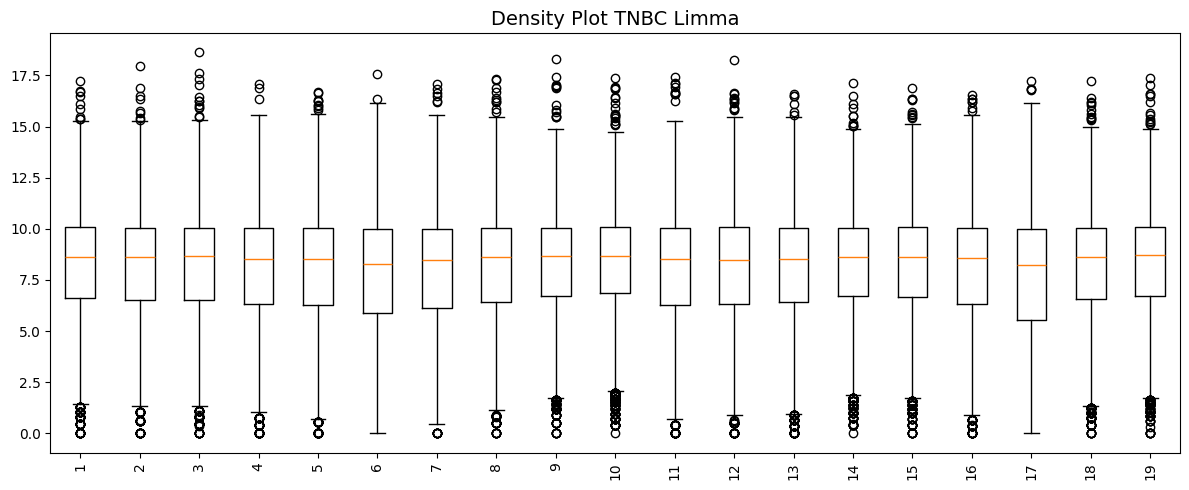

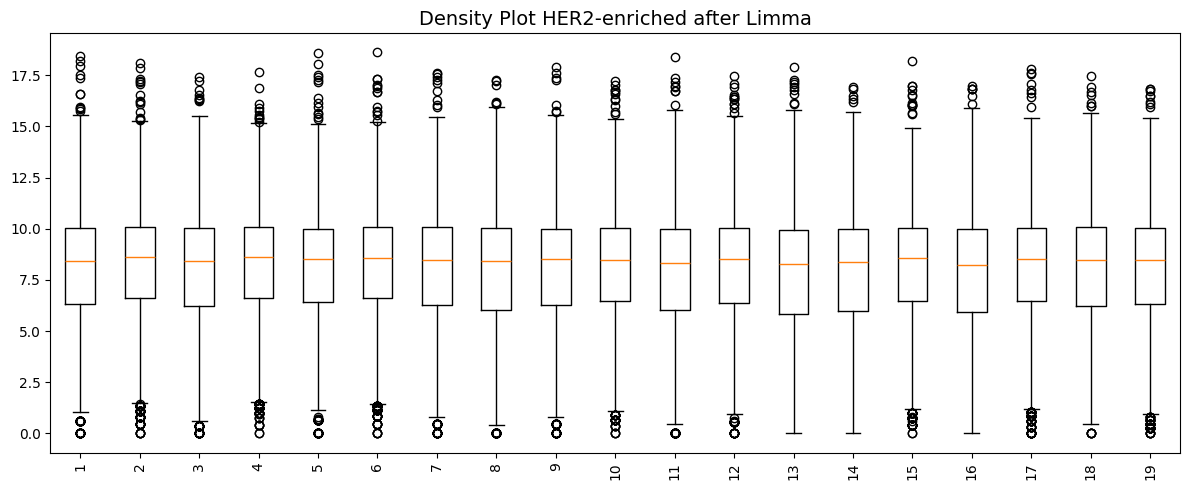

In [ ]:


X = expr_sub.T.to_numpy(dtype=float)

D = np.asarray(design)
cols = np.array(getattr(design, "columns", [f"C{i}" for i in range(D.shape[1])]))
y = cols[np.argmax(D, axis=1)]



X_her2 = X[y == "HER2-enriched", :] 
X_Luminal_A = X[y== "Luminal A", :]
X_Luminal_B = X[y== "Luminal B", :]
X_TNBC = X[y== "TNBC", :]

box_plot(data=X_Luminal_A, title="Box plots Luminal A after Limma",
         type_cancer=None, range_min=1,range_max=20)

box_plot(data=X_Luminal_B, title="Box plots Luminal B after Limma",
         type_cancer=None, range_min=1,range_max=20)

box_plot(data=X_TNBC, title="Box plots TNBC Limma",
         type_cancer=None, range_min=1,range_max=20)

box_plot(data=X_her2, title="Box plots HER2-enriched after Limma",
         type_cancer=None, range_min=1,range_max=20)

<font size="4">Density plot after Limma</font>

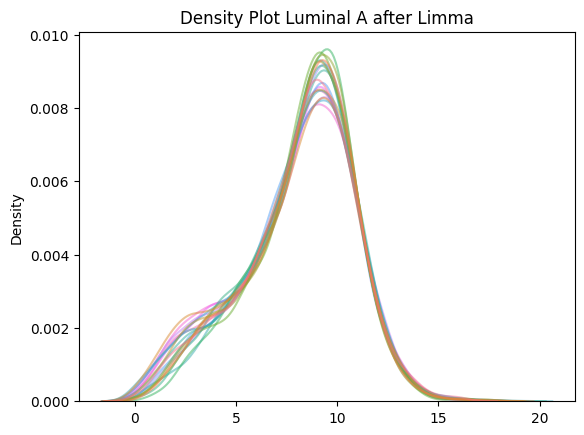

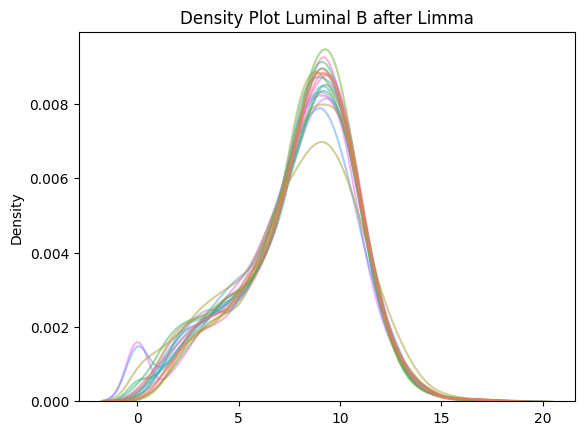

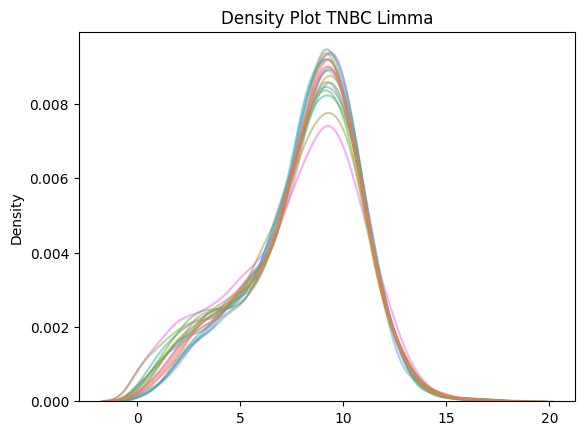

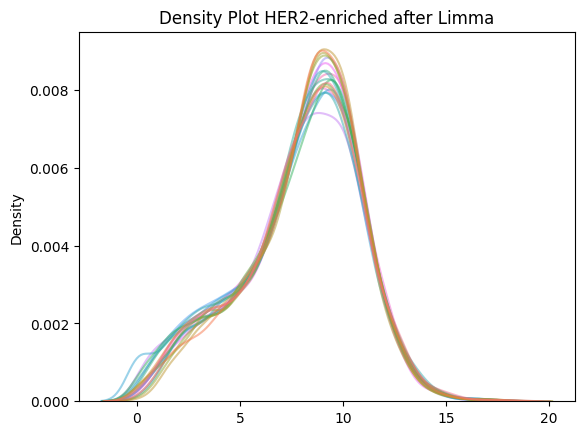

In [49]:
density_plot(data=X_Luminal_A, title="Density Plot Luminal A after Limma",
         type_cancer=None, range_min=1,range_max=20)

density_plot(data=X_Luminal_B, title="Density Plot Luminal B after Limma",
         type_cancer=None, range_min=1,range_max=20)

density_plot(data=X_TNBC, title="Density Plot TNBC Limma",
         type_cancer=None, range_min=1,range_max=20)

density_plot(data=X_her2, title="Density Plot HER2-enriched after Limma",
         type_cancer=None, range_min=1,range_max=20)

<font size="4">PCA after Limma</font>

In [50]:

X = expr_sub.T.to_numpy(dtype=float)


D = np.asarray(design) #Get the array of the one Hot vector
cols = np.array(getattr(design, "columns", [f"C{i}" for i in range(D.shape[1])])) #Get the columns in the desing array
y = cols[np.argmax(D, axis=1)] #Gets the indices of the maximum value in the columns

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=4, random_state=0)

components = pca.fit_transform(X_scaled)


df_plot = pd.DataFrame(components, columns=["PC1", "PC2", "PC3", "PC4"])
df_plot["Subtype"] = y


labels = {
        "PC1": f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
        "PC2": f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
        "PC3": f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)",
        "PC4": f"PC4 ({pca.explained_variance_ratio_[3]*100:.1f}%)",
    }


fig = px.scatter_matrix(
        df_plot,
        dimensions=["PC1", "PC2", "PC3", "PC4"],
        labels=labels,
        color="Subtype",
        title=f"PCA of subtypes after Limma Luminal A, Luminal B,TNBC,HER2-enriched",
        opacity=0.7,
        color_discrete_map={f"{cols[0]}": "#fa09fa",
                            f"{cols[1]}": "#1f77b4",
                            f"{cols[2]}": "#ec3204",
                            f"{cols[3]}": "#49fa09",
                            },
)
fig.show()